# Time Dilation by Example
Let's apply our knowledge of Special Relativity (SR) and General Relativity (GR) to predict the phenomenon of time dilation.

Special Relativity, which describes spacetime far from a significant gravity field, explains how a stationary observer perceives time passing slower for a moving observer when the relative velocity between them is very large.

General Relativity, which deals with gravity, explains how time slows down in proximity to a large gravitational acceleration.

The [wikipedia page for time dilation](https://en.wikipedia.org/wiki/Time_dilation) provides a derivation of these effects and a handy plot showing time dilation in Earth orbit. Let's try to recreate it.

![time dilation plot](./Time_Dilation_vs_Orbital_Height.png)

## The Schwartzschild solution

Let's see how far we can get by crunching the numbers on the [Schwartzschild solution](https://en.wikipedia.org/wiki/Schwarzschild_solution) to the Einstein field equations as they appear on Wikipedia.

$$
d{t_E}^2 = \Big(1 + \frac{2 U}{c^2} \Big) d{t_c}^2 - \Big(1 + \frac{2 U}{c^2} \Big)^{-1} v^2, \quad U = \Sigma \frac{-GM_i}{r_i}, \quad v^2 = \frac{dx^2 + dy^2 + dz^2}{c^2}
$$

where:
* $dt_E$ is a small increment of proper time $t_E$ (an interval that could be recorded on an atomic clock),
* $dt_c$ is a small increment in the coordinate $t_c$ (coordinate time),
* $dx$, $dy$, $dz$, are small increments in the three coordinates $x$, $y$, $z$ of the clock's position,
* $\Sigma \frac{-GM_i}{r_i}$ represents the sum of the Newtonian gravitational potentials due to the masses in the neighborhood, based on their distances $r_i$ from the clock. This sum includes any tidal potentials.

Next we rearrange the formula to the form we want to plot: proper time over coordinate time with respect to orbital altitude at a given instant.

$$
\frac{dt_E}{dt_c} = \sqrt{1 + \frac{2U}{c^2} - \frac{v^2}{c^2} + \Big(\frac{c^2}{2U} + 1 \Big)^{-1} \frac{{v_r^2}}{c^2}}
$$

where:
* $v_r$ is the radial velocity,
* $U = \Sigma \frac{-GM_i}{r_i}$ is the total Newtownian potential


## Assumptions & Simplifications
We can make a few simplifications to the full equation in order to recreate the plot from Wikipedia.

* All orbits under consideration are circular.
* All orbits are computed at the same latitude and longitude, so only altitude varies. We choose the coordinates that line up with the ECI frame so changing altitude corresponds to motion along $x$, exactly radial from Earth's center.
* Mean parameters are used for Earth's radius and mass.
* The only significant Newtonian gravitational potentials are from Earth, Moon, Jupiter, and Sun.

## Code

We'll use Python because it's quick and perfect for playing around like this.

* Astrodynamics, let's use [astropy](https://docs.astropy.org/en/stable/constants/index.html#module-astropy.constants) and the gravitational potential classes from [gala](https://gala.adrian.pw/en/latest/potential/index.html).
* Import [matplotlib](https://matplotlib.org/) for plotting, as is tradition.
* For math and vectors, we'll use good ol' [numpy](https://numpy.org/).
* We're going to want a table of data, so we'll add [pandas](https://pandas.pydata.org/) too.

In [1]:
import astropy
import gala
import numpy as np
import pandas as pd

In [43]:
from astropy import units as u
import numpy as np

altitudes = np.logspace(start=2, stop=5, num=1_000, base=10) * u.km
r = altitudes + 1 * u.astrophys.earthRad

We need to pick a moment in time to look up where celestial bodies are. Let's use New Year's Day 2024.

In [81]:
from astropy.coordinates import solar_system_ephemeris, get_body
from astropy.time import Time
from astropy.units.astrophys import solMass, earthMass, jupiterMass
from collections import namedtuple


moonMass = 7.34767309e22 * u.kg # this one isn't built in to astropy :()

t = Time("2024-01-01T00:00:00Z")

# let's make a class that is easier to read
Body = namedtuple("Body", ["name", "position", "mass", "potential"])

# all positions are in the GCRF (ECI) frame as SkyCoord objects
with solar_system_ephemeris.set('builtin'):
    earth = Body("Earth", get_body('earth', t), 1 * earthMass, None)
    moon = Body("Moon", get_body('moon', t), 1 * moonMass, None)
    jupiter = Body("Jupiter", get_body('jupiter', t), 1 * jupiterMass, None)
    sun = Body("Sun", get_body('sun', t), 1 * solMass, None)

bodies = [earth, moon, jupiter, sun]

# we want to reference each in cartesian coordinates and km
for body in bodies:
    body.position.representation_type = 'cartesian'

Let's use Gala to build the gravitational potential fields from all the celestial bodies we care about.

In [80]:
from astropy.coordinates import SkyCoord
from astropy.units import Unit
import gala.potential as gp
from gala.units import UnitSystem

custom_unit_sys = UnitSystem(u.km, u.kg, u.s, u.radian) # use familiar units for plots


def skycoord_to_xyz_scalar(coord: SkyCoord, unit: Unit = u.km):
    # gala wants a sequence of scalars, not SkyCoords or Quantities
    return coord.x.to(unit).value, coord.y.to(unit).value, coord.z.to(unit).value


potentials = [
    gp.KeplerPotential(m=body.mass, origin=skycoord_to_xyz_scalar(body.position), units=custom_unit_sys)
    for body in bodies
]

total_potential = gp.KeplerPotential(m=0 * u.kg,  units=custom_unit_sys) # dummy potential so we can sum the rest
for p in potentials:
    # for some reason gp.BasePotential doesn't let us use sum() so we have to use a workaround
    total_potential += p


Before we continue, we should take a step back and ask ourselves if the calculations so far agree with our intuition.

We expect the gravitational potential to increase exponentially as we get closer to a body. Is that what happens?

In [116]:
import matplotlib.pyplot as plt


labels = [body.name for body in bodies]

# There's a bug in the gala method so we're going to steal their plot function and mod it
def plot_rotation_curve(potential, R_grid, t=0.0, ax=None, labels=None, loglog=False, **plot_kwargs):
    """
    Plot the rotation curve or circular velocity curve for this potential on the
    input grid of cylindrical radii.

    Parameters
    ----------
    R_grid : array-like
        A grid of radius values to compute the rotation curve at. This should be a
        one-dimensional grid.
    t : quantity-like (optional)
        The time to evaluate at.
    ax : matplotlib.Axes (optional)
    labels : iterable (optional)
        List of axis labels. Set to False to disable adding labels.
    plot_kwargs : dict
        kwargs passed to plot().

    Returns
    -------
    fig : `~matplotlib.Figure`
    ax : `~matplotlib.Axes`

    """

    if not hasattr(R_grid, "unit"):
        R_grid = R_grid * potential.units["length"]

    xyz = np.zeros((3,) + R_grid.shape) * potential.units["length"]
    xyz[0] = R_grid

    vcirc = potential.circular_velocity(xyz, t=t)

    if labels is None:
        labels = [
            f"$R$ [{potential.units['length']:latex_inline}]",
            r"$v_{\rm circ}$ " + f"[{potential.units['speed']:latex_inline}]",
        ]

    if ax is None:
        fig, ax = plt.subplots()

    if labels is not False:
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])

    plot_kwargs.setdefault("marker", "")
    plot_kwargs.setdefault("linestyle", plot_kwargs.pop("ls", "-"))
    plot_kwargs.setdefault("linewidth", plot_kwargs.pop("lw", 1))

    if loglog:
        plot_fn = ax.loglog
    else:
        plot_fn = ax.plot
    plot_fn(
        R_grid.to_value(potential.units["length"]),
        vcirc.to_value(potential.units["speed"]),
        **plot_kwargs,
    )
    return ax

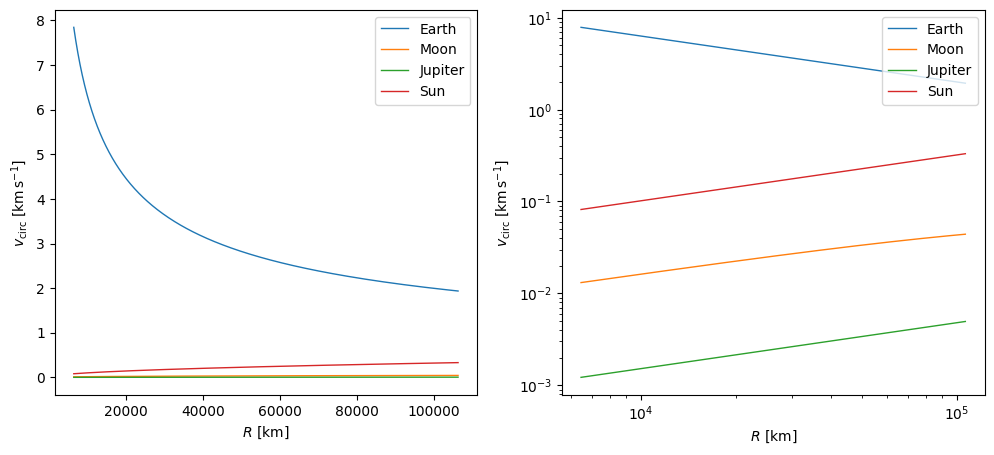

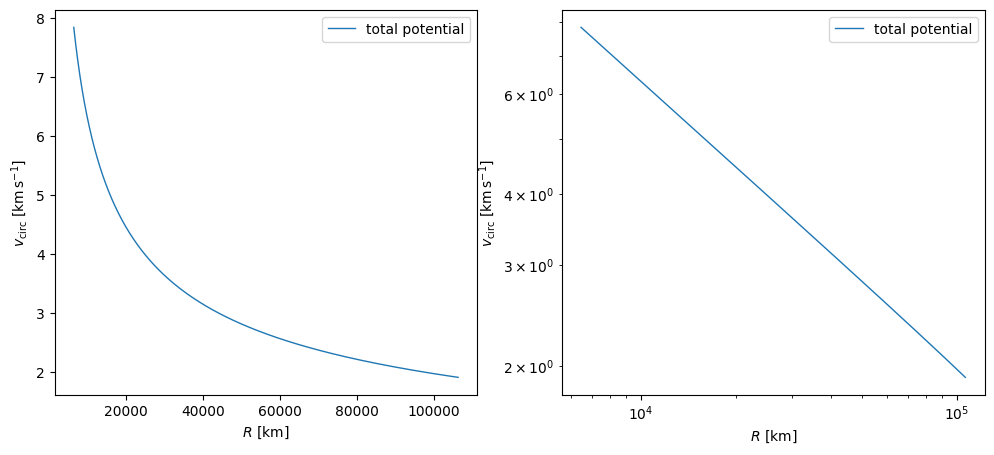

In [134]:
fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
for p in potentials:
    ax[0] = plot_rotation_curve(p, r, loglog=False, ax=ax[0])
ax[0].legend(labels)

for p in potentials:
    ax[1] = plot_rotation_curve(p, r, loglog=True, ax=ax[1])
ax[1].legend(labels)

Excellent, this is the shape we expected. As our $R$ value moves away from the center of Earth, the gravitational potential decreases. Moving in the $x$ direction in the ECI frame at this moment would move us closer to and Sun, and we again observe the potential from these bodies increasing with $x$.

Now we total everything up and double check that yes, the total potential is the sum of all the others.

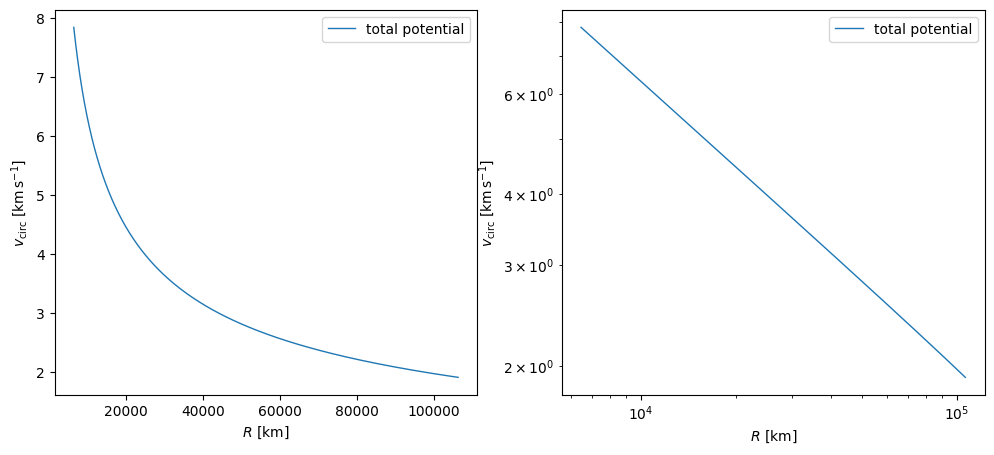

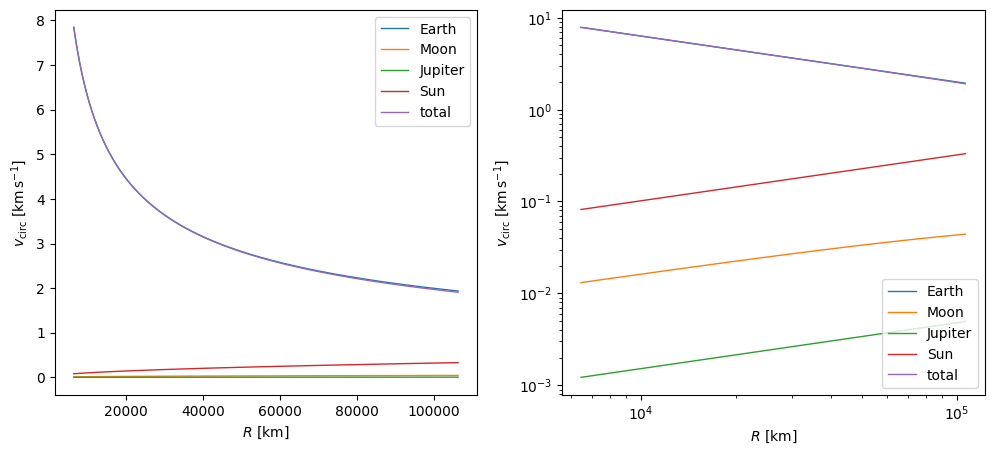

In [136]:
fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
for axis, is_log_plot in zip(ax, [False, True]):
    axis = plot_rotation_curve(total_potential, r, loglog=is_log_plot, ax=axis)
    axis.legend(["total potential"])

fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
for p in potentials + [total_potential]:
    ax[0] = plot_rotation_curve(p, r, loglog=False, ax=ax[0])
ax[0].legend(labels + ["total_potential"])

for p in potentials + [total_potential]:
    ax[1] = plot_rotation_curve(p, r, loglog=True, ax=ax[1])
ax[1].legend(labels + ["total_potential"])

Rather than coding up everything ourselves, let's leverage Gala's tools to make life more convenient. In particular, we should leverage the [Orbit](https://gala.adrian.pw/en/latest/api/gala.dynamics.PhaseSpacePosition.html#gala.dynamics.Orbit) object to represent locations along our x-axis. This object plugs into Gala's gravitational potential objects so we can refer to a point in the potential field and ask things like "what velocity would give a circular orbit?" and "what is the total potential energy?"

In [185]:
from astropy.coordinates import CartesianRepresentation, GCRS
from gala.dynamics import Orbit, PhaseSpacePosition


pos = CartesianRepresentation(x=r.value, y=[0]*len(r), z=[0]*len(r), unit=u.km)
vel = total_potential.circular_velocity(pos.get_xyz())
vel

<Quantity [7.8437187 , 7.84329858, 7.84287561, 7.84244978, 7.84202106,
           7.84158943, 7.84115489, 7.8407174 , 7.84027695, 7.83983352,
           7.83938709, 7.83893764, 7.83848514, 7.83802959, 7.83757096,
           7.83710922, 7.83664436, 7.83617637, 7.8357052 , 7.83523086,
           7.83475331, 7.83427254, 7.83378852, 7.83330123, 7.83281065,
           7.83231676, 7.83181954, 7.83131897, 7.83081501, 7.83030766,
           7.82979689, 7.82928268, 7.828765  , 7.82824383, 7.82771915,
           7.82719094, 7.82665917, 7.82612382, 7.82558486, 7.82504228,
           7.82449605, 7.82394614, 7.82339254, 7.82283521, 7.82227413,
           7.82170929, 7.82114065, 7.82056818, 7.81999188, 7.8194117 ,
           7.81882763, 7.81823963, 7.8176477 , 7.81705178, 7.81645188,
           7.81584795, 7.81523997, 7.81462791, 7.81401176, 7.81339147,
           7.81276703, 7.81213841, 7.81150558, 7.81086852, 7.81022719,
           7.80958157, 7.80893163, 7.80827735, 7.80761869, 7.80695563,
      

In [5]:
def time_dilation(orbit):
    pass

To sanity check ourselves, we should calculate the dilation at a few real satellites and plot them too.

-367953.193273311